# Using Option Volume to predict Stock Prices

**Intro:** 
----
Speculation has become an attractive but risky way to amass lots of money in today's financial markets. 

If you are not familiar with the terms Calls and Puts, they are essentially contracts that allow investors to place 'bets' on a stock. They give you the right to buy or short 100 shares at a specified expiration date. 

If you think a stock's price will rise in the foreseable future, you might buy a Call option for a significant discount as an alternative to buying 100 shares of a stock. **Calls** are associated with the expectation that the stocks price will rise in the future and vice versa for puts. 

If you think the price of a stock will decline in the foreseable futre, you might buy a Put option as an alternative to borrowing 100 shares to buy them back at a cheaper price. **Puts** are the expectation that the stock's price will fall in the future

Option contracts are a way for market participants to invest in stocks without the capital to purchase large amounts of shares. It should be noted that these contracts can expose the investor to adverse risk, and the monetary value of these contracts fluctuate violently in volitile market conditions. 

**Background of data collection:** 
----
I began collecting Options data in the latter part of 2021. I used the `yfinance` python package which obtains data from the Yahoo Finance API. It was neccesary to aggregate and drop unused columns to satisfy the 10 MB threshold. For the stocks that I have provided, there is about 100 days of volume/OpenInterest data. 

**Overview of topics discussed:**
----
We will explore the relationships if any, between Option Volume, and Open interest. **Volume** is the number of contracts that are traded per day. **Open Interest** is the total number of outstanding contracts those that are already open. Open interest provides a more accurate picture of the options trading activity and whether money flows into the options markets are increasing or decreasing.

More simpily put: 

Call/Put Volume: Indicates contracts traded in a given period.
Call/Put Open Interest: Indicates the number of active contracts. 

**Goal**
----
We will use the Incremental Regression Model to atempt to predict the stock price using the Call/Put Volume and Open Interest. 


Lets Load in Some functions that we previously have seen in our homework notebooks to visualize matricies, and tables. 

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 



from IPython.display import display, Math
%matplotlib inline

# From: https://stackoverflow.com/questions/17129290/numpy-2d-and-1d-array-to-latex-bmatrix
def nparray_to_bmatrix(a):
    """Returns a LaTeX bmatrix"""
    assert len(a.shape) <= 2, 'bmatrix can at most display two dimensions'
    lines = str(a).replace('[', '').replace(']', '').splitlines()
    rv = [r'\begin{bmatrix}']
    rv += ['  ' + ' & '.join(l.split()) + r'\\' for l in lines]
    rv +=  [r'\end{bmatrix}']
    return '\n'.join(rv)


%matplotlib inline

And now for the data, note that this data is not like a normal Tibble, it is multi-indexed. Again, most of the data manipulation was done locally (as the file size was to large to provide here).However, I have provided an HTML file in the folder for transparency. 

The stocks or rather ETF's (bundle of stocks) included are listed below, as well as the long names associated with them. 

In [3]:
df = pd.read_csv('Option_chain.csv', index_col=[0, 1]).T
display(df)
stocks = set(df.columns.get_level_values('Stock_name'))
print(f"Stocks in the dataframe: {stocks}")

long_names = {
            'QQQ':'Invesco QQQ Trust (NASDAQ)',
            'IWM':'iShares Russell 2000 ETF (EMERGING MARKETS)',
            'BNO':'United States Brent Oil Fund, LP',
            'TLT':'iShares 20+ Year Treasury Bond ETF (RISK FREE ASSETS)',
            'SPY':'SPDR S&P 500 ETF Trust (500 LARGEST COMPANIES)',
            'GLD':'SPDR Gold Shares (GOLD)'}


Metric     Closing_price                                                  \
Stock_name           AAL        AAPL        ABBV        ABNB        AFRM   
2021-11-15     20.320000  150.000000  116.839996  207.210007  147.990005   
2021-11-16     19.840000  151.000000  116.419998  207.039993  151.289993   
2021-11-17     19.860001  153.490005  117.349998  199.110001  151.720001   
2021-11-18     19.389999  157.869995  117.070000  204.330002  139.130005   
2021-11-19     19.280001  160.550003  116.239998  196.419998  136.160004   
...                  ...         ...         ...         ...         ...   
2022-04-19     19.590000  167.399994  156.350006  170.119995   37.029999   
2022-04-20     19.480000  167.229996  156.699997  164.550003   34.759998   
2022-04-21     20.219999  166.419998  158.520004  157.910004   32.900002   
2022-04-22     20.180000  161.789993  154.990005  156.089996   31.160000   
2022-04-25           NaN         NaN         NaN         NaN         NaN   

Metric                                                             ...  \
Stock_name        AMC         AMD         AMZN   ARDX        ASAN  ...   
2021-11-15  42.680000  146.490005  3545.679932  1.120  136.399994  ...   
2021-11-16  42.599998  152.449997  3540.699951  1.050  135.289993  ...   
2021-11-17  42.130001  151.339996  3549.000000  1.020  131.600006  ...   
2021-11-18  40.410000  155.020004  3696.060059  0.988  136.979996  ...   
2021-11-19  40.869999  155.410004  3676.570068  1.000  137.190002  ...   
...               ...         ...          ...    ...         ...  ...   
2022-04-19  18.680000   96.930000  3162.310059  0.790   32.860001  ...   
2022-04-20  17.340000   94.019997  3079.959961  0.771   30.540001  ...   
2022-04-21  16.850000   89.849998  2965.919922  0.746   29.480000  ...   
2022-04-22  16.520000   88.139999  2887.000000  0.748   29.090000  ...   
2022-04-25        NaN         NaN          NaN    NaN         NaN  ...   

Metric     Put_volume                                                         \
Stock_name       VUZI       VXX      WBA    WEAT      WFC       WMT      XLE   
2021-11-15     3536.0       NaN      NaN     NaN      NaN   68790.0      NaN   
2021-11-16     2438.0       NaN      NaN     NaN      NaN  101433.0      NaN   
2021-11-17     6603.0       NaN      NaN     NaN      NaN   30508.0      NaN   
2021-11-18     6787.0       NaN      NaN     NaN      NaN   31082.0      NaN   
2021-11-19     5943.0       NaN      NaN     NaN      NaN   26730.0      NaN   
...               ...       ...      ...     ...      ...       ...      ...   
2022-04-19      930.0   50252.0      NaN  1762.0   9021.0   18774.0  15218.0   
2022-04-20     3013.0   40337.0   6941.0    80.0  29160.0   23897.0  33089.0   
2022-04-21     2954.0   44656.0   5345.0   654.0  30594.0   18748.0  15218.0   
2022-04-22      930.0  126361.0  18810.0    80.0  29525.0   27278.0  15218.0   
2022-04-25     2828.0   37857.0   1892.0    80.0  24748.0   23542.0  55463.0   

Metric                                  
Stock_name       XLF      XLV      XOM  
2021-11-15       NaN      NaN      NaN  
2021-11-16       NaN      NaN      NaN  
2021-11-17       NaN      NaN      NaN  
2021-11-18       NaN      NaN      NaN  
2021-11-19       NaN      NaN      NaN  
...              ...      ...      ...  
2022-04-19   68153.0   9919.0   6964.0  
2022-04-20   92191.0  24695.0  30176.0  
2022-04-21   51337.0   9919.0   7902.0  
2022-04-22   80662.0   9919.0  11058.0  
2022-04-25  135042.0  10796.0  11602.0  

[111 rows x 708 columns]

Stocks in the dataframe: {'XLE', 'V', 'CLSK', 'JPM', 'WEAT', 'ROKU', 'SHY', 'RUN', 'GOVZ', 'RBLX', 'CSCO', 'LI', 'ABBV', 'TSN', 'TWTR', 'PEP', 'TBT', 'IBM', 'CMRE', 'QQQ', 'AAL', 'LMT', 'C', 'UWMC', 'BA', 'K', 'MSFT', 'SPY', 'WMT', 'XLF', 'CHGG', 'SQ', 'LC', 'MOS', 'CTRA', 'FANG', 'IEF', 'GLD', 'MARA', 'MO', 'UBER', 'F', 'FCEL', 'JKS', 'SPWR', 'TSLA', 'VXX', 'CVX', 'CVS', 'NVDA', 'GOOG', 'UUP', 'WBA', 'TMV', 'BKKT', 'NTR', 'MU', 'ABNB', 'HOOD', 'COIN', 'VUZI', 'ARDX', 'AAPL', 'BNO', 'SBUX', 'XOM', 'RTX', 'GE', 'SONO', 'QS', 'QCOM', 'AMC', 'KO', 'WFC', 'AMD', 'SPI', 'FB', 'PYPL', 'CTVA', 'INTU', 'SONY', 'RRC', 'TLT', 'DWAC', 'ICLN', 'IWM', 'ENPH', 'SPOT', 'XLV', 'OXY', 'RKT', 'MRK', 'SOL', 'SLV', 'LCID', 'SNAP', 'EOG', 'AMZN', 'DCFC', 'DKNG', 'GME', 'UNG', 'CLX', 'ASAN', 'MMM', 'UPS', 'NFLX', 'TGT', 'CCJ', 'SNOW', 'IEI', 'PFE', 'DIS', 'HD', 'GSL', 'VALE', 'AFRM', 'PLTR'}


In [4]:
# Look at only one stock
display(df.xs(key = 'SPY', axis = 1, level = 'Stock_name'))

Metric,Closing_price,Share_volume,Call_openInterest,Call_volume,Put_openInterest,Put_volume
2021-11-15,467.429993,46980500.0,7026217.0,2034693.0,13766820.0,2378405.0
2021-11-16,469.279999,48857500.0,7049096.0,1674900.0,13812381.0,2029899.0
2021-11-17,468.140015,47858300.0,6982916.0,1384479.0,13816352.0,1727194.0
2021-11-18,469.730011,50625600.0,7209721.0,1493625.0,14228129.0,1517216.0
2021-11-19,468.890015,57315600.0,7539485.0,2019583.0,14728841.0,2759557.0
...,...,...,...,...,...,...
2022-04-19,445.040009,77821000.0,4884693.0,1229175.0,9375489.0,2177210.0
2022-04-20,444.709991,65224400.0,5075228.0,1899513.0,10044436.0,2623684.0
2022-04-21,438.059998,85417300.0,5014298.0,2198247.0,9887380.0,2893747.0
2022-04-22,426.040009,132354400.0,5445689.0,2645529.0,10301749.0,3708456.0


Lets quickly visualize the relationship between the closing price of a stock and the volumes/openinterest of the predictor values. 

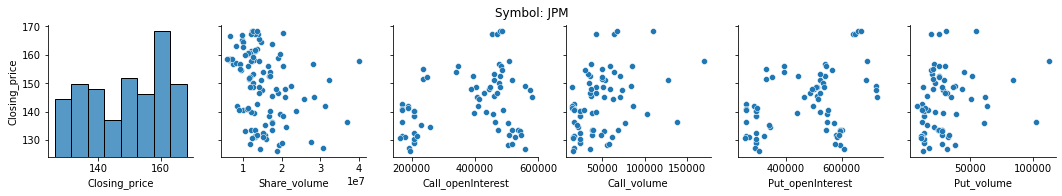

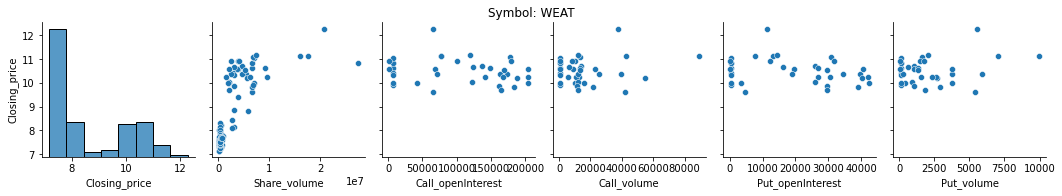

In [5]:
import seaborn as sns 
def symbol_data(symbol, df):
    df = df.xs(key = symbol, axis = 1, level = 'Stock_name')
    g = sns.pairplot(df, y_vars = 'Closing_price')
    g.fig.suptitle(f'Symbol: {symbol}', y = 1.05)
    return g 

[symbol_data(g, df) for g in list(stocks)[3:5]]

> It looks like different stocks have differnt relationships with volume, as well as the Call/Put Volume/Open Interest volume we have provided. 

Lets start by looking at all of the data at once, the traditional linear regression method.

We wish to determine model parameters $\theta^*$ that minimizes the residual squared error: $$r^2_2 =||X\theta - y||_{2}^{2}$$

### But first lets define a function that returns two **matricies** X, and y, for a particular stock in the dataframe `df`. 

_Remember that we need to add in the vector of ones to X matrix to indicate the intercept._

In [6]:
def df_to_matrix(symbol, response = 'Closing_price', show =False):
    reg_df = df.xs(key =symbol, axis = 1, level = 'Stock_name').copy().dropna()
    X = reg_df.drop(response, axis = 1).to_numpy()
    X=np.insert(X,X.shape[1],1.0,axis=1)
    y = reg_df[response].to_numpy()[:, np.newaxis]
    if show != False: 
        from IPython.display import display, Math
        print(f'${symbol} : {long_names[symbol]}')
        print(f'\tX Shape: {X.shape}')
        print(f'\ty Shape: {y.shape}')
        print('--------------------------------')
        print('  Showing the first 5 rows')
        display(Math(r'X = {}, y = {}'.format(nparray_to_bmatrix(X[:5,:5].round()), nparray_to_bmatrix(y[:5]))))    
    else: 
        return X, y

X, y = df_to_matrix('SPY', 'Closing_price')
df_to_matrix(symbol = 'SPY', response = 'Closing_price', show = True)

$SPY : SPDR S&P 500 ETF Trust (500 LARGEST COMPANIES)
	X Shape: (108, 6)
	y Shape: (108, 1)
--------------------------------
  Showing the first 5 rows


<IPython.core.display.Math object>

>Above I have shown the first 5 observations for both the X and y matricies. Each column in X refers to the original columns in the dataframe above. That is the Share Volume, Call Open Interest, Call Volume, Put Open Interest, and Put Volume, Note that at the end of matrix X there exist a column of all 1s to indicate the intercept

Next let us recall the estimate the normal equations of the linear least squares regression problem, however since we are dealing with an overdetermined system (We have more observations than variables) we want to alternativley minimize the sum of square residual error.

$$ \theta^* = {\arg\min_\theta} \|X \theta - y\|_2^2. $$

$$X^T X \theta^* = X^T y.$$



Alternatively, we can make use of the QR Decomposition method of solving this overdetermined system

Recall that the normal equations can be transformed if we substitute $X = QR$:

$$
\begin{eqnarray}
        X^T X \theta^* & = & X^T y \\
  R^T Q^T Q R \theta^* & = & R^T Q^T y \\
            R \theta^* & = & Q^T y.
\end{eqnarray}
$$

Lets preview the `np.linalg.qr` function for a clear understanding of how it works, and how to check the stability. 

In [7]:
Q, R = np.linalg.qr(X)
print("Shape of Q:", Q.shape, "\n")
print("Shape of R:", R.shape)

# Stability Check 
cond_R = np.linalg.cond(R)
cond_X = np.linalg.cond(X)
print("Condition of X:", cond_X)
print("Condition or R:", cond_R)

Shape of Q: (108, 6) 

Shape of R: (6, 6)
Condition of X: 1286180794.1522276
Condition or R: 1286180794.1522276


Now lets create a function that returns coefficients from the QR Algorithim on all stocks. After checking if the data is numerically stable, we will save the outputs to a dictionary. 

In [8]:
def solve_qr(symbol, stable_check = False):
    X, y = df_to_matrix(symbol, 'Closing_price', show = False)
    import scipy as sp 
    Q, R = np.linalg.qr(X)
    b = Q.T.dot(y)
    #print(symbol, b.shape, R.shape)
    if R.shape[0] != R.shape[1]:
        return None
    else:
        theta = sp.linalg.solve_triangular(R, b) 
        
        # Check to see if R is numerically stable
        cond_R = np.linalg.cond(R)
        cond_X = np.linalg.cond(X)
        if stable_check != False:
            from math import isclose
            if isclose(cond_R, cond_X) == True:
                print(f"X and R Appear to be Numerically Stable for stock: ${symbol}")
            else: 
                print(f'{symbol} ---->',"X and are Not Numercially Stable")
        return {'theta': theta, 'X_vals': X, 'y_vals': y}


qr_coefs = {stock: solve_qr(stock, False) for stock in stocks if solve_qr(stock, False) is not None}

# preview:
qr_coefs['AAPL']['theta']

stocks = list(qr_coefs.keys())

Now lets just check how the model is doing, we will use the thetas above to solve the linear equation: 
$$y_i \approx x_{i,0} \theta_0 + x_{i,1} \theta_1 + \cdots + x_{i,n-1} \theta_{n-1} + \theta_n,$$

In matrix form: 
$$
  y \approx X \theta,
$$

We can also evaluate this against the Sk_learn linear regression equivelant. 

In [9]:
def LR_sklearn(symbol):
    df_single = df.xs(key = symbol, axis = 1, level = 'Stock_name').dropna()
    X = df_single.drop('Closing_price', axis = 1)
    y = df_single['Closing_price']
    
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)
    from sklearn.linear_model import LinearRegression
    lm = LinearRegression()
    lm.fit(X_train,y_train)
    theta_sk = lm.coef_
    predictions_sk = lm.predict(X_test)
    return {'theta_sk':theta_sk, 'prediction_sk': predictions_sk}

sk_coefs = {stock: LR_sklearn(stock) for stock in stocks }

def evaluate_qr_algo(symbol):
    symbol = symbol.upper()
    theta_qr, X, y = qr_coefs[symbol]['theta'], qr_coefs[symbol]['X_vals'], qr_coefs[symbol]['y_vals']
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=101)
    predictions_qr = X_test.dot(theta_qr)
    
    fig, axes = plt.subplots(nrows = 1, ncols =2, figsize = (10,4))
    
    axes[0].scatter(y_test,predictions_qr)
    axes[1].scatter(y_test,sk_coefs[symbol]['prediction_sk'])
    axes[0].set_xlabel('Y_True')
    axes[0].set_ylabel('Prediction')
    axes[0].set_title(f'${symbol} QR ALGO')
    
    axes[1].set_xlabel('Y_True')
    axes[1].set_ylabel('Prediction')
    axes[1].set_title(f'${symbol} SK LEARN')
    plt.show()
    return {'y_test': y_test, 'qr_predictions': predictions_qr}

def evaluate_qr_algo(symbol):
    symbol = symbol.upper()
    theta_qr, X, y = qr_coefs[symbol]['theta'], qr_coefs[symbol]['X_vals'], qr_coefs[symbol]['y_vals']
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=101)
    predictions_qr = X_test.dot(theta_qr)
    return {'y_test': y_test, 'qr_predictions': predictions_qr}


qr_preds = {stock: evaluate_qr_algo(stock) for stock in stocks }

Nice, seems like the methods are yielding similar results. Lets have a look at the error produced by each methods' coefficients that are returned. 

In [44]:
def rel_diff(x, y, ord=1):
    """
    Computes ||x-y|| / ||y||. Uses 2-norm by default;
    override by setting 'ord'.
    """
    return np.linalg.norm (x - y, ord=ord) / np.linalg.norm (y, ord=ord)


for i in stocks: 
    er_term = rel_diff(sk_coefs[i]['theta_sk'], qr_coefs[i]['theta'] )
    print(f'${i} Error: {er_term}')
    


$XLE Error: 1.000001648731143
$V Error: 1.000001536642916
$CLSK Error: 1.0001919089598441
$JPM Error: 1.0000047381166608
$WEAT Error: 1.0000087774716955
$ROKU Error: 1.0000128055951607
$SHY Error: 1.0000046178109383
$RUN Error: 1.00002087863409
$GOVZ Error: 1.0771496051755962
$RBLX Error: 1.0000498850446697
$CSCO Error: 1.0000142980643036
$LI Error: 1.0000144816872019
$ABBV Error: 1.0000183670241927
$TWTR Error: 1.0000062031335843
$TBT Error: 1.0000062742471554
$IBM Error: 1.0000017022492211
$CMRE Error: 1.0002235535581778
$QQQ Error: 1.0000000550695953
$AAL Error: 1.0000031158570528
$LMT Error: 1.0000257345602224
$C Error: 1.000003007734324
$UWMC Error: 1.0001374917609578
$BA Error: 1.0000206329030166
$K Error: 1.00000605368323
$MSFT Error: 1.0000020323228065
$SPY Error: 1.0000000717058615
$WMT Error: 1.0000015393175923
$XLF Error: 1.0000001645444265
$CHGG Error: 1.0000560588632332
$SQ Error: 1.0000062468687878
$CTRA Error: 1.0000157006819748
$IEF Error: 1.0000026782533025
$GLD Error:

> Above it seems that the Sklearn looks similar qr method.. Now The question arisis: Which is a better fit? 

In [45]:
from sklearn import metrics 
#print('R^2 QR:', metrics.explained_variance_score(y_test, predictions_qr))
#print('R^2 SKLEARN:',metrics.explained_variance_score(y_test, predictions_sk))

# save this into a dataframe and view it 
for i in stocks: 
    print(f'${i} R^2 QR:', metrics.explained_variance_score(qr_preds[i]['y_test'], qr_preds[i]['qr_predictions']))
    print(f'${i} R^2 SKLEARN:',metrics.explained_variance_score(qr_preds[i]['y_test'],sk_coefs[i]['prediction_sk'] ))


$XLE R^2 QR: 0.6518415324707905
$XLE R^2 SKLEARN: 0.5749417687871698
$V R^2 QR: 0.07526687165847845
$V R^2 SKLEARN: -0.07404210574082448
$CLSK R^2 QR: 0.4558826299104999
$CLSK R^2 SKLEARN: 0.08877832036462863
$JPM R^2 QR: 0.49838227809868374
$JPM R^2 SKLEARN: 0.4072556000299724
$WEAT R^2 QR: 0.4399506675010767
$WEAT R^2 SKLEARN: 0.30423578962399145
$ROKU R^2 QR: 0.5144277436862666
$ROKU R^2 SKLEARN: 0.42058479343943644
$SHY R^2 QR: 0.8952281117448724
$SHY R^2 SKLEARN: 0.8784763383875221
$RUN R^2 QR: 0.385909374459407
$RUN R^2 SKLEARN: 0.1332971736565195
$GOVZ R^2 QR: 0.6600291926044006
$GOVZ R^2 SKLEARN: 0.6407602139134307
$RBLX R^2 QR: 0.49503928326596014
$RBLX R^2 SKLEARN: 0.3200549055532558
$CSCO R^2 QR: 0.5344046920772308
$CSCO R^2 SKLEARN: 0.2012204519066696
$LI R^2 QR: 0.5409387343683056
$LI R^2 SKLEARN: 0.3793173054075295
$ABBV R^2 QR: 0.5929761328413735
$ABBV R^2 SKLEARN: -24.845231959749373
$TWTR R^2 QR: 0.6940977733872148
$TWTR R^2 SKLEARN: 0.46463207601159484
$TBT R^2 QR: 0.

> The QR Method is outpreforming the SK learn Implementation. Cheers!

### Now lets implement the online batch regression we previously saw in notebook 12.

Recall the Online or incremental regression problem: 

* Choose any initial guess, $\tilde{\theta}(0)$, such as $\tilde{\theta}(0) \leftarrow 0$.
* For each observation $(y_k, \hat{x}_k^T)$, do the update:

  * $\tilde{\theta}(k+1) \leftarrow \tilde{\theta}_k + \Delta_k$,
  
  where $\Delta_k = \phi \cdot \hat{x}_k \left( y_k - \hat{x}_k^T \tilde{\theta}(k) \right)$.

In [13]:
def estimate_coeffs (X, y):
    """
    Solves X*theta = y by a linear least squares method.
    """
    result = np.linalg.lstsq (X, y, rcond=None)
    theta = result[0]
    return theta

def rel_diff(x, y, ord=2):
    """
    Computes ||x-y|| / ||y||. Uses 2-norm by default;
    override by setting 'ord'.
    """
    return np.linalg.norm (x - y, ord=ord) / np.linalg.norm (y, ord=ord)

def lms(X, y, theta_0=None, PHI=1e-6):
    """Implements the LMS algorithm for the system X theta = y."""
    (m, n) = X.shape
    
    if theta_0 is None:
        theta_k = np.zeros((n))
    else:
        theta_k = theta_0
    theta_k = np.reshape(theta_k, (n, 1))
        
    for k in range(m):
        x_k = X[k:k+1, :].T
        r_k = y[k] - x_k.T.dot(theta_k)
        delta_k = PHI * r_k * x_k
        theta_k = theta_k + delta_k
    return theta_k

def calc_ssqr(theta, X, y):
    r = X.dot(theta) - y
    return r.T.dot(r)

def model_evaluations(X, y, theta):
    y_hat = X.dot(theta)
    prediction_error = y - y_hat
    return prediction_error

def qr_solver(X, y):
    import scipy as sp 

    Q, R = np.linalg.qr(X)
    b = Q.T.dot(y)
    theta = sp.linalg.solve_triangular(R, b) 
    return theta

Lets define the number of observations the model will se 

In [19]:
def print_online_lms(symbol,batch_size=1):
    X, y = qr_coefs[symbol]['X_vals'], qr_coefs[symbol]['y_vals']
    theta = qr_coefs[symbol]['theta']
    bs = batch_size
    X_start, y_start = X[:bs, :], y[:bs]
    X_hybrid, y_hybrid = X[bs:, :], y[bs:]

    lambdas = np.linalg.eigvals(X_start.T.dot(X_start))
    lambda_max = max(lambdas)
    lambda_min = min(lambdas)
    phi_factor = 2.0 / (lambda_max + lambda_min)

    theta_pure = lms(X_start, y_start, PHI = phi_factor)
    theta_start = estimate_coeffs(X_start, y_start)
    online_theta = lms(X_start, y_start, theta_0 = theta_start, PHI = phi_factor)
    
    print(f"=== {symbol} Sum of squared errors ===")
    print("True:", calc_ssqr(theta, X, y))
    print("Batch-{}:".format(bs), calc_ssqr(theta_start, X, y))
    print("LMS(phi={}):".format(phi_factor), calc_ssqr(theta_pure, X, y))
    print("Batch (k <= %d) + LMS:" % batch_size, calc_ssqr(online_theta, X, y))
    print('-------------------------------------------------------')
    print(f"=== {symbol} Relative error in the coefficients (theta) ===")
    print("Batch:", rel_diff(theta, theta_pure))
    print("Batch-{}:".format(bs), rel_diff(theta_start, theta))
    print("LMS(phi={}):".format(phi_factor), rel_diff(theta_pure, theta))
    print("Batch (k <= %d) + LMS:" % bs, rel_diff(online_theta, theta))
    print('\n'*2)
    
 
 

In [20]:
for i in stocks: 
    print_online_lms(i)

=== XLE Sum of squared errors ===
True: [[504.00779686]]
Batch-1: [[87152.92932711]]
LMS(phi=2.177678150399478e-15): [[950277.29722163]]
Batch (k <= 1) + LMS: [[87152.92932711]]
-------------------------------------------------------
=== XLE Relative error in the coefficients (theta) ===
Batch: 19463847.551930744
Batch-1: 0.9999999999999993
LMS(phi=2.177678150399478e-15): 0.9999999999999998
Batch (k <= 1) + LMS: 0.9999999999999993



=== V Sum of squared errors ===
True: [[6824.62528603]]
Batch-1: [[535142.9445954]]
LMS(phi=2.522532421037176e-14): [[5617289.38344038]]
Batch (k <= 1) + LMS: [[535142.9445954]]
-------------------------------------------------------
=== V Relative error in the coefficients (theta) ===
Batch: 4546261.0070273755
Batch-1: 0.9999999999999939
LMS(phi=2.522532421037176e-14): 1.0
Batch (k <= 1) + LMS: 0.9999999999999939



=== CLSK Sum of squared errors ===
True: [[732.57720334]]
Batch-1: [[17373.46535424]]
LMS(phi=2.821223048078861e-13): [[104425.72843789]]
Bat

JPM (71, 6)


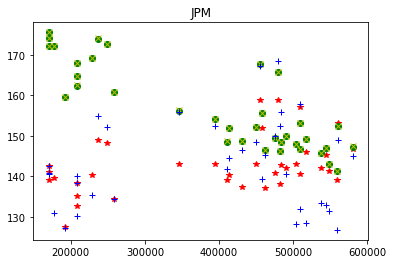

WEAT (37, 6)


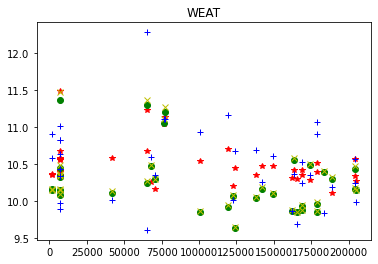

ROKU (88, 6)


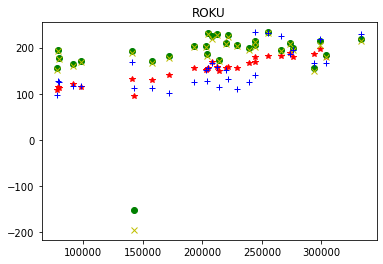

SHY (108, 6)


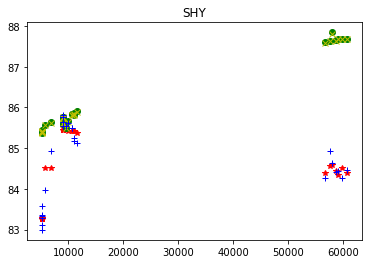

RUN (80, 6)


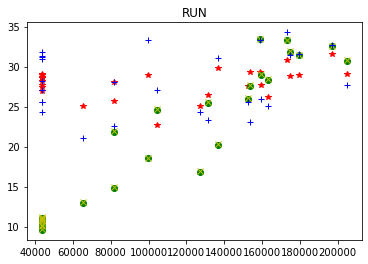

GOVZ (105, 6)


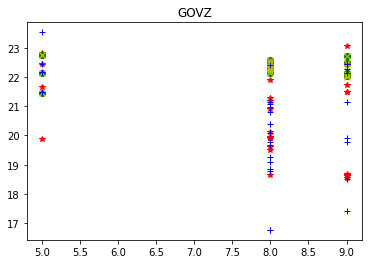

RBLX (106, 6)


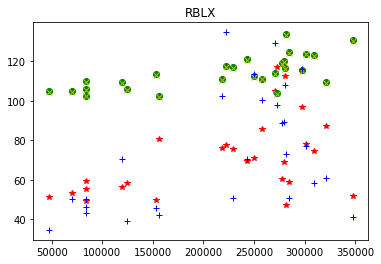

In [40]:
def plot_online_lms(symbol,batch_size=1):
    X, y = qr_coefs[symbol]['X_vals'], qr_coefs[symbol]['y_vals']
    theta = qr_coefs[symbol]['theta']
    bs = batch_size
    X_start, y_start = X[:bs, :], y[:bs]
    X_hybrid, y_hybrid = X[bs:, :], y[bs:]

    lambdas = np.linalg.eigvals(X_start.T.dot(X_start))
    lambda_max = max(lambdas)
    lambda_min = min(lambdas)
    phi_factor = 2.0 / (lambda_max + lambda_min)

    theta_pure = lms(X_start, y_start, PHI = phi_factor)
    theta_start = estimate_coeffs(X_start, y_start)
    online_theta = lms(X_start, y_start, theta_0 = theta_start, PHI = phi_factor)
    print(symbol,X.shape)
    
    STEP = int(X.shape[0]/ batch_size)
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.plot(X[::STEP, 1], X.dot(theta)[::STEP], 'r*') # red - true
    ax1.plot(X[::STEP, 1], X.dot(theta_start)[::STEP], 'go') # green - batch
    #ax1.plot(X[::STEP, 1], X.dot(theta_pure)[::STEP], 'mo') # magenta - pure LMS
    ax1.plot(X[::STEP, 1], X.dot(online_theta)[::STEP], 'yx') # yellow - hybrid
    ax1.plot(X[::STEP, 1], y[::STEP], 'b+') # blue - data
    ax1.set_title(f'{symbol}')
    plt.show()
    
for i in stocks[3:10]: 
    plot_online_lms(i, batch_size=25)

Great, We have reached the end. The plots seem to show that the online estimates in yellow, are close to the true estimates for most stocks. However some, differ significantly. As I continue to download data each day, I will continue to observe the ouputs of the online regression, as this should not be a call for someone to buy all of one stock. But we did a pretty good job at estimating linear coefficients for each stock, so Horray! Now time to work on those final exam practice problems!


Cheers!

In [32]:
tmp = qr_coefs['SPY']['X_vals']
tmp[::1,4]

array([2378405., 2029899., 1727194., 1517216., 2759557., 3584609.,
       3483689., 2998171., 2984883., 3625983., 3791748., 5241687.,
       3957685., 3577019., 3134306., 3155426., 1545180., 2056868.,
       3219697., 2018806., 1928267., 2386053., 2065022., 3619358.,
       3436183., 2250553., 2059267., 2124857., 1216107., 1086561.,
       1145645., 1232556., 1806943.,  747662., 1937634., 2108276.,
       2422320., 1632625., 2495326., 2063818., 2549893., 2856945.,
       1946209., 1837522., 3406973., 4600333., 2079199., 1603123.,
       1408747., 1920057., 1965079., 1596633., 2030581., 1479131.,
       1854849., 1759519., 1081413., 2033094., 2005035., 6085134.,
       4364627., 1575848., 1329918., 1397529., 2013197., 3517305.,
       1471010., 4599644., 4120518., 4310334., 3036416., 3812198.,
       2869936., 3899474., 3380155., 3879483., 4392278., 2794533.,
       3016924., 3130475., 2381532., 2800033., 2857269., 2677066.,
       3486150., 3091022., 2543171., 2064481., 3719558., 24961